In [3]:
import quimb as qu
import numpy as np
import quimb.tensor as qtn
from quimb.tensor.tensor_core import (
    ensure_dict,
    rand_uuid,
    tensor_contract,
    TensorNetwork,
)
import sys, os

N_MPI = 16
N_OMP = N_MKL = N_OPENBLAS = 1
# Number of cores used when performing linear algebra operations: N_MPI * N_OMP. Make sure this is less or equal to the number of total threadings.

os.environ['OMP_NUM_THREADS'] = f'{N_OMP}'
os.environ['MKL_NUM_THREADS'] = f'{N_MKL}'
os.environ['OPENBLAS_NUM_THREADS'] = f'{N_OPENBLAS}'
os.environ['MKL_DOMAIN_NUM_THREADS'] = f'{N_MKL}'
os.environ['MKL_DYNAMIC'] = 'FALSE'
os.environ['OMP_DYNAMIC'] = 'FALSE'


def single_qubit_layer(circ, gate_round=None, g=1.0, h=0.0):
    """Apply a parametrizable layer of single qubit ``U3`` gates.
    """
    for i in range(circ.N):
        if type(h) is tuple:
            # random field list
            hi = h[i]
            circ.apply_gate(
                'RZ', -2*hi, i, 
                gate_round=gate_round, parametrize=True)
        else:
            # constant fields
            if h != 0.0:
                circ.apply_gate(
                    'RZ', -2*h, i, 
                    gate_round=gate_round, parametrize=True)
            
        circ.apply_gate(
            'RX', -2*g, i, 
            gate_round=gate_round, parametrize=True)
        
        
def two_qubit_layer(circ, gate2='RZZ', gate_round=None, J=1.0):
    """Apply a layer of constant entangling gates.
    """
    regs = range(0, circ.N - 1)
    
    for i in regs[::2]:
        circ.apply_gate(
            gate2, -2*J, i, i + 1, gate_round=gate_round,contract='split-gate')
    
    for i in regs[1::2]:
        circ.apply_gate(
            gate2, -2*J, i, i + 1, gate_round=gate_round,contract='split-gate')

def ansatz_circuit(n, depth, gate2='RZZ', g=1.0, J=1.0, h=0.0, **kwargs):
    """Construct a circuit of single qubit and entangling layers.
    """
    circ = qtn.Circuit(n, **kwargs, tags='ROUND_0')
    
    for r in range(depth):
        # two qubit gate layer
        two_qubit_layer(circ, gate2=gate2, gate_round=r+1, J=J)
        # single qubit gate layer
        single_qubit_layer(circ, gate_round=r+1, g=g, h=h)
        
    return circ

def mps_gate_with_mpo_lazy(self, mpo):
    """Apply an MPO to an MPS lazily, i.e. nothing is contracted, but the new
    TN object has the same outer indices as the original MPS.
    """
    mps_calc = self.copy()
    mpo_calc = mpo.copy()

    outerid = self.site_ind_id
    innerid = rand_uuid() + "{}"

    mps_calc.site_ind_id = innerid
    mpo_calc.lower_ind_id = innerid
    mpo_calc.upper_ind_id = outerid

    mps_calc |= mpo_calc

    mps_calc._site_ind_id = outerid

    return mps_calc


def fix_inds_quimb(tn, ind_list, ind_value_list):
    """
    Fix a list of indices of the tensor network.
    Used for TN slicing.
    """
    tn_config = tn.copy()
    for ind, ind_value in zip(ind_list, ind_value_list):
        tn_config = tn_config.isel_({ind: ind_value})
    return tn_config

def generate_Kicked_Ising_peps(n, depth, g=1.0, J=1.0, h=0.0):
    circ = ansatz_circuit(n, depth, gate2='RZZ', g=g, J=J, h=h)
    psi = circ.psi.copy()
    for i in range(1,depth+1):
        for site in psi.sites:
            psi.contract_tags_([psi.site_tag_id.format(site), f'ROUND_{i}'], inplace=True, which='all')
    peps_psi = qtn.PEPS.from_TN(psi, Lx=depth+1, Ly=n, x_tag_id="ROUND_{}", y_tag_id="I{}", site_tag_id="I{},{}")
    for x in range(0,depth+1):
        for y in range(n):
            tn = peps_psi[[peps_psi.x_tag_id.format(x), peps_psi.y_tag_id.format(y)]]
            tn.add_tag(peps_psi.site_tag_id.format(x,y))
    return psi, peps_psi

def exactly_contract_psi(psi, depth):
    psi = psi.copy()
    for i in range(0, depth):
        for site in psi.sites:
            psi.contract_tags_([f'ROUND_{i}'], inplace=True, which='any')
        psi.contract_tags_([f'ROUND_{i}',f'ROUND_{i+1}'], inplace=True, which='any')
    return psi

def amplitude(peps_psi, chi, inds_values, inds=None, direction='xmax'):
    if inds is None:
        n = len(inds_values)
        inds = [f'k{ind}' for ind in range(n)]
    amplitude_ = 0
    peps_config = fix_inds_quimb(peps_psi, inds, inds_values)
    if direction == 'xmax':
        amplitude_ = peps_config.contract_boundary_from_xmax(xrange=(1, peps_config.Lx-1), max_bond=chi).contract()
    elif direction == 'xmin' or direction == 'mpo':
        # MPS contraction / MPO contraction
        # amplitude = peps_config.contract_boundary_from_xmin(xrange=(0, 1), max_bond=chi).contract()
        amplitude_ = peps_config.contract()
    elif direction == 'ymax':
        amplitude_ = peps_config.contract_boundary_from_ymax(yrange=(1, peps_config.Ly-1), max_bond=chi).contract()
    elif direction == 'yboth':
        left_amplitude = peps_config.contract_boundary_from_ymin(yrange=(0, peps_config.Ly//2-1), max_bond=chi)
        amplitude_ = left_amplitude.contract_boundary_from_ymax(yrange=(peps_config.Ly//2, peps_config.Ly-1), max_bond=chi).contract()
        # print(amplitude, peps_config.contract())
    return amplitude_

def amplitude_exact(peps_psi, inds_values, inds=None):
    if inds is None:
        n = len(inds_values)
        inds = [f'k{ind}' for ind in range(n)]
    peps_config = fix_inds_quimb(peps_psi, inds, inds_values)
    amplitude = peps_config.contract()
    return amplitude

def enumerate_bitstrings(n):
    bitstrings = np.empty((2**n, n), dtype=int)
    for i in range(2**n):
        bitstrings[i] = [int(x) for x in list(f'{i:0{n}b}')]
    return bitstrings

def config2index(config):
    # transform a binary string to an index
    return int(''.join([str(x) for x in config]), 2)

def index2config(index, n):
    # transform an index to a binary configuration
    return tuple([int(x) for x in list(f'{index:0{n}b}')])

def amplitudes(n, depth, chi, direction='xmax', J=1.0, g=1.0, h=0.0):
    import time
    from quimb.utils import progbar as Progbar
    if direction == 'xmax':
        # no reuse
        circ, peps_psi = generate_Kicked_Ising_peps(n, depth, J=J, g=g, h=h)
        configs = enumerate_bitstrings(n)
        amplitude_dict = {}
        normalizations = 0
        pg = Progbar(total=len(configs))
        t0 = time.time()
        for config in configs:
            amp = amplitude(peps_psi, chi, config, direction=direction)
            normalizations += abs(amp)**2
            amplitude_dict[tuple(config)] = amp
            pg.update()
        t1 = time.time()
        pg.close()
        for config in amplitude_dict.keys():
            amplitude_dict[config] /= np.sqrt(normalizations)

    elif direction == 'xmin':
        circ, peps_psi = generate_Kicked_Ising_peps(n, depth, J=J, g=g, h=h)
        peps_psi = peps_psi.contract_boundary_from_xmin(xrange=(0, peps_psi.Lx-1), max_bond=chi, canonize=True).contract()
        configs = enumerate_bitstrings(n)
        amplitude_dict = {}
        normalizations = 0
        pg = Progbar(total=len(configs))
        t0 = time.time()
        for config in configs:
            amp = amplitude(peps_psi, chi, config, direction=direction)
            normalizations += abs(amp)**2
            amplitude_dict[tuple(config)] = amp
            pg.update()
        t1 = time.time()
        pg.close()
        for config in amplitude_dict.keys():
            amplitude_dict[config] /= np.sqrt(normalizations)
            
    elif direction == 'mpo':
        circ, peps_psi = generate_Kicked_Ising_peps(n, depth, J=J, g=g, h=h)
        peps_psi = peps_psi.contract_boundary_from_xmax(xrange=(1, peps_psi.Lx-1), max_bond=chi, canonize=True).contract()
        configs = enumerate_bitstrings(n)
        amplitude_dict = {}
        normalizations = 0
        pg = Progbar(total=len(configs))
        t0 = time.time()
        for config in configs:
            amp = amplitude(peps_psi, chi, config, direction=direction)
            normalizations += abs(amp)**2
            amplitude_dict[tuple(config)] = amp
            pg.update()
        t1 = time.time()
        pg.close()
        for config in amplitude_dict.keys():
            amplitude_dict[config] /= np.sqrt(normalizations)
    
    else:
        # transverse direction, direction='ymax'
        circ, peps_psi = generate_Kicked_Ising_peps(n, depth, J=J, g=g, h=h)
        configs = enumerate_bitstrings(n)
        amplitude_dict = {}
        normalizations = 0
        pg = Progbar(total=len(configs))
        t0 = time.time()
        for config in configs:
            amp = amplitude(peps_psi, chi, config, direction=direction)
            normalizations += abs(amp)**2
            amplitude_dict[tuple(config)] = amp
            pg.update()
        t1 = time.time()
        pg.close()
        for config in amplitude_dict.keys():
            amplitude_dict[config] /= np.sqrt(normalizations)

    print(f'Amplitudes computation time: {t1-t0:.2f} s, depth={depth}')
    amp_time = t1-t0
    return amplitude_dict, amp_time

def amplitudes_exact(n, depth, J=1.0, g=1.0, h=0.0):
    import time
    circ, peps_psi = generate_Kicked_Ising_peps(n, depth, J=J, g=g, h=h)
    configs = enumerate_bitstrings(n)
    state_vector = peps_psi.contract()
    amplitude_dict = {}
    normalizations = 0
    t0 = time.time()
    for config in configs:
        amp = amplitude_exact(state_vector, config)
        normalizations += abs(amp)**2
        amplitude_dict[tuple(config)] = amp
    t1 = time.time()
    print(f'Exact simulation normalization: {normalizations:.2f}')
    print(f'Exact amplitudes computation time: {t1-t0:.2f} s, depth={depth}')
    amp_time = t1-t0
    return amplitude_dict, amp_time

def whole_density_matrix(amplitude_dict, n):
    rho = np.zeros((2**n, 2**n), dtype=complex)
    for i in range(2**n):
        for j in range(i, 2**n):
            config_i = index2config(i, n)
            config_j = index2config(j, n)
            rho[i, j] = amplitude_dict[config_i] * amplitude_dict[config_j].conjugate()
            rho[j, i] = rho[i, j].conjugate()
    return rho

def state_vector(amplitude_dict, n):
    psi = np.zeros(2**n, dtype=complex)
    for i in range(2**n):
        config_i = index2config(i, n)
        psi[i] = amplitude_dict[config_i]
    return psi

def partial_trace(rho, trace_qubits, reverse=True):
    n = int(np.log2(rho.shape[0]))
    dimensions = [2]*n
    for j in trace_qubits:
        dimension_traced = int(dimensions[j])
        if reverse:
            dimensions_left = dimensions[j+1:]
            dimensions_right = dimensions[:j]
            dimensions = dimensions_right + dimensions_left
        else:
            dimensions_left = dimensions[:j]
            dimensions_right = dimensions[j+1:]
            dimensions = dimensions_left + dimensions_right
        
        d_left = int(np.prod(dimensions_left))
        d_right = int(np.prod(dimensions_right))
        
        rho = rho.reshape(d_left, dimension_traced, d_right, d_left, dimension_traced, d_right)
        rho = rho.trace(axis1=1, axis2=4).reshape(d_left*d_right, d_left*d_right)
    
    return rho
        
def partial_trace_bipartition(rho, reverse=True):
    """
    Return the reduced density matrix of the first half of the system."""
    n = int(np.log2(rho.shape[0]))
    if n % 2 != 0:
        raise ValueError('The number of qubits must be even.')
    trace_qubit_no = int(n/2)
    rho = rho.reshape(2**trace_qubit_no, 2**trace_qubit_no, 2**trace_qubit_no, 2**trace_qubit_no)
    if reverse:
        rho = rho.trace(axis1=0, axis2=2)
    else:
        rho = rho.trace(axis1=1, axis2=3)
    return rho

def partial_trace_vec(vec, trace_systems=None, dimensions=None, reverse=True):
    """
    Partial trace over subsystems of multi-partite vector.

    Args:
        vec (vector_like): complex vector N
        trace_systems (list(int)): a list of subsystems (starting from 0) to
                                  trace over.
        dimensions (list(int)): a list of the dimensions of the subsystems.
                                If this is not set it will assume all
                                subsystems are qubits.
        reverse (bool): ordering of systems in operator.
            If True system-0 is the right most system in tensor product.
            If False system-0 is the left most system in tensor product.

    Returns:
        ndarray: A density matrix with the appropriate subsystems traced over.
    """
    
    n = int(np.log2(len(vec)))
    if dimensions is None:
        dimensions = [2] * n
    if trace_systems is None:
        # bipartition
        trace_systems = list(range(n // 2, n))
    # trace sys positions
    if reverse:
        dimensions = dimensions[::-1]
        trace_systems = len(dimensions) - 1 - np.array(trace_systems)

    rho = vec.reshape(dimensions)
    rho = np.tensordot(rho, rho.conj(), axes=(trace_systems, trace_systems))
    d = int(np.sqrt(np.product(rho.shape)))

    return rho.reshape(d, d)

def von_neumann_entropy(rho):
    """Compute entanglement entropy of the reduced density matrix. Logarithm has base 2."""
    eigvals = np.linalg.eigvalsh(rho)
    eigvals = eigvals[eigvals > 1e-15]
    return -np.sum(eigvals * np.log2(eigvals)) 

def maximum_entanglement_entropy(n):
    """Maximum entanglement entropy of n qubits. Logarithm has base 2."""
    return n

def compute_entanglement_entropy(n, depth, chi, direction='xmax', J=1.0, g=1.0, h=0.0, partial_trace_func=partial_trace_bipartition):
    if chi==-1:
        return compute_entanglement_entropy_exact(n, depth, J=J, g=g, h=h)
    print(f'depth={depth}')
    amplitude_dict, amp_time = amplitudes(n, depth, chi, direction=direction, J=J, g=g, h=h)
    if n<10:
        partial_trace_func=partial_trace_bipartition
        rho = whole_density_matrix(amplitude_dict, n)
        rho = partial_trace_func(rho)
    else:
        partial_trace_func=partial_trace_vec
        vec = state_vector(amplitude_dict, n)
        rho = partial_trace_func(vec)
    return von_neumann_entropy(rho), np.trace(rho), amp_time

def compute_entanglement_entropy_exact(n, depth, J=1.0, g=1.0, h=0.0, partial_trace_func=partial_trace_vec):
    print(f'depth={depth}')
    circ_psi, peps_psi = generate_Kicked_Ising_peps(n, depth, J=J, g=g, h=h)
    vec = exactly_contract_psi(circ_psi, depth).to_dense()
    rho = partial_trace_func(vec)
    return von_neumann_entropy(rho), np.trace(rho), None

def compute_entanglement_entropy_exact_volume_law(n, depth, J=1.0, g=1.0, h=0.0, partial_trace_func=partial_trace_vec):
    print(f'depth={depth}')
    circ_psi, peps_psi = generate_Kicked_Ising_peps(n, depth, J=J, g=g, h=h)
    vec = exactly_contract_psi(circ_psi, depth).to_dense()
    rho_list = []
    for l in range(n//2):
        rho = partial_trace_func(vec, trace_systems=list(range(int((n-l)/2)))+list(range(int((n+l)/2), n)))
        rho_list.append(rho)
    entropy_list = [von_neumann_entropy(rho) for rho in rho_list]
    return entropy_list, None, None

def entanglement_spectrum(rdm, n):
    eigvals = np.linalg.eigvalsh(rdm)
    return eigvals[::-1][:n]

def plot_bipartition_entropy_dynamics(n, total_depth, chi, chi_mps, entropies_func, entropies_mps, J=1.0, g=0.5, h=0.1, func=True):
    import matplotlib.pyplot as plt
    # print(J, g, h)
    fig, ax = plt.subplots()
    ax.plot(range(1, total_depth+1), entropies_func, label=f'TN function entropy, $\chi={chi}$')
    ax.plot(range(1, total_depth+1), entropies_mps, label=f'MPS entropy, $\chi={chi_mps}$')

    ax.set(xlabel='t', ylabel='Entropy',
              title=f'Bipartite EE dynamics of {n}-qubit 1D Kicked Ising model, $J={J}$, $g={g}$, $h={h}$')
    ax.legend()
    plt.show()

In [4]:
randpeps = qtn.PEPS.rand(2,2,2)
randpeps.contract_boundary_from

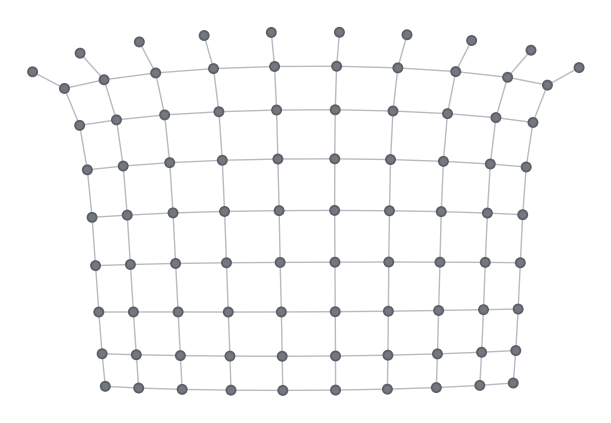

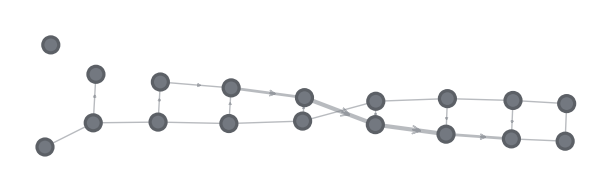

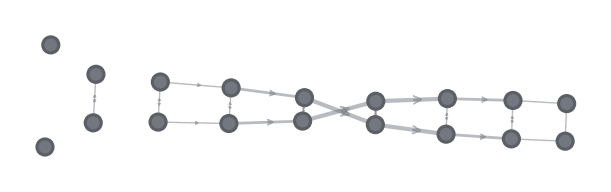

(0.03283043488435506-0.014853608470555748j) (0.03283043488435498-0.014853608470555807j) (0.03283043488435499-0.014853608470555663j)


In [2]:
n = 10
total_depth = 8
chi_func_list = [32]
max_bond = 32
# direction = 'xmin'
J = np.pi/4
g = np.pi/4
h = 0.2

psi, peps_psi = generate_Kicked_Ising_peps(n, total_depth, J=J, g=g, h=h)
inds = [f'k{ind}' for ind in range(n)]
inds_values = [1]*n
peps_config = fix_inds_quimb(peps_psi, inds, inds_values)
peps_config.draw()
left_amp = peps_config.contract_boundary_from_ymin(yrange=(0, peps_config.Ly//2-1), max_bond=max_bond)
right_amp = left_amp.contract_boundary_from_ymax(yrange=(peps_config.Ly//2, peps_config.Ly-1), max_bond=max_bond)
pure_right_amp = peps_config.contract_boundary_from_ymax(yrange=(1, peps_config.Ly-1), max_bond=max_bond).contract()
pure_left_amp = peps_config.contract_boundary_from_ymin(yrange=(0, peps_config.Ly-2), max_bond=max_bond).contract()
peps_config.contract_boundary_from_ymin(yrange=(0, peps_config.Ly-2), max_bond=max_bond).draw()
right_amp.draw()
print(peps_config.contract(), pure_left_amp, pure_right_amp)

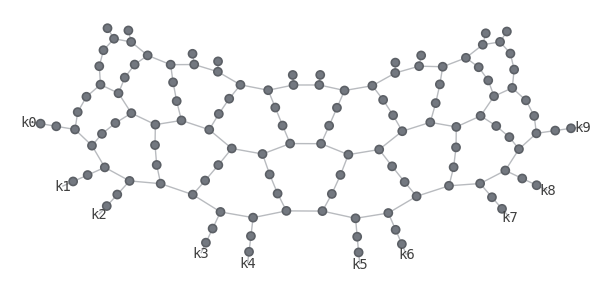

In [3]:
circ = ansatz_circuit(n, depth=3, gate2='RZZ', g=g, J=J, h=h)
psi = circ.psi.copy()
psi.draw()

In [4]:
peps_config.contract()

(0.006545888804831058-0.00020760898574245752j)

In [5]:
peps= qtn.PEPS.rand

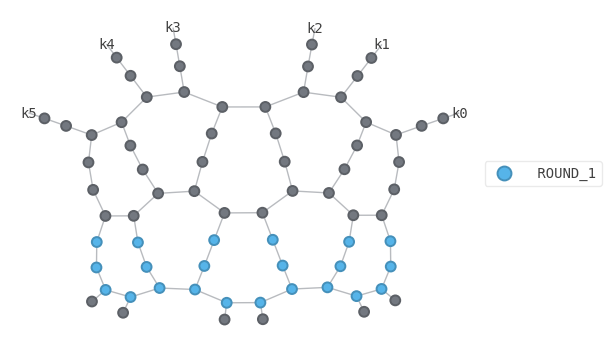

TensorNetworkGenVector(tensors=72, indices=87)

In [6]:
circ0 = ansatz_circuit(n=6, depth=3,h=1.0)
circ0.psi.draw(color=['ROUND_1'])
circ0.psi

9


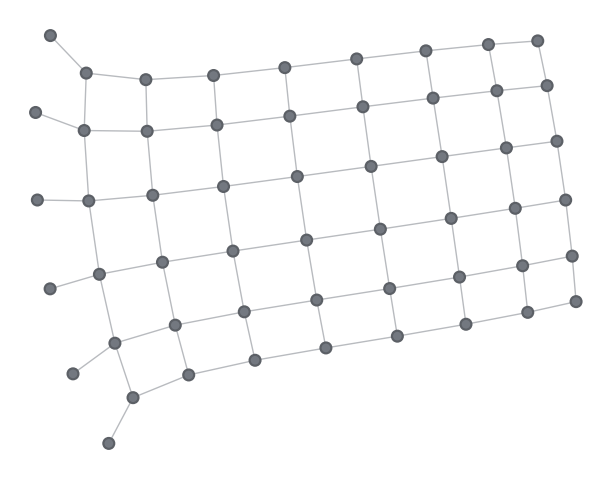

(0.05486306826066377-0.021354384230715194j)


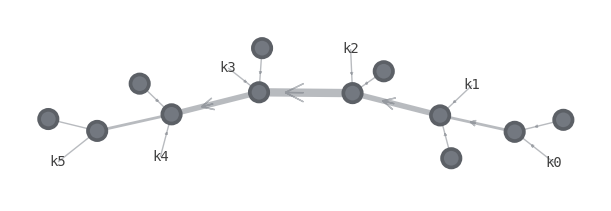

(0.05486306826066346-0.021354384230714472j)
(0.054863068260663714-0.021354384230715083j)
(0.05486306826066349-0.02135438423071445j)


In [60]:
n = 6
total_depth = 8
chi = 64
# direction = 'xmin'
J = 1.0
g = 0.5
h = 0.1

psi, peps_psi = generate_Kicked_Ising_peps(n, total_depth, J=J, g=g, h=h)
print(peps_psi.Lx)
inds = [f'k{ind}' for ind in range(n)]
inds_values = [1]*n
peps_config = fix_inds_quimb(peps_psi, inds, inds_values)
peps_config.draw()
print(peps_config.contract())
top_amp = peps_psi.contract_boundary_from_xmax(xrange=(1,8),max_bond=chi,canonize=False)
top_amp1 = peps_psi.contract_boundary_from_xmax(xrange=(0,8),max_bond=chi,canonize=False)
bot_amp = peps_psi.contract_boundary_from_xmin(xrange=(1,8),max_bond=chi,canonize=False)
top_amp.draw()
psi_config = fix_inds_quimb(top_amp, inds, inds_values)
print(psi_config.contract())
psi_config1 = fix_inds_quimb(bot_amp, inds, inds_values)
print(psi_config1.contract())
psi_config2 = fix_inds_quimb(top_amp1, inds, inds_values)
print(psi_config2.contract())

In [12]:
top_amp

PEPS(tensors=70, indices=114, Lx=9, Ly=10, max_bond=2)

In [14]:
rand_peps = qtn.PEPS.rand(2, 2, bond_dim=2)
rand_peps.contract_boundary_from_xmax(xrange=(0, 1), max_bond=2)

PEPS(tensors=2, indices=5, Lx=2, Ly=2, max_bond=2)

[0.91727859 0.04844396 0.03047629 0.00380116]


In [11]:
enumerate_bitstrings(8)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 1]])

In [30]:
from quimb.utils import progbar as Progbar
n = 16
circ, peps_psi = generate_Kicked_Ising_peps(n=n, depth=20, J=J, g=g, h=h)
chi = 4
configs = enumerate_bitstrings(n)
amplitude_dict = {}
normalizations = 0
pg = Progbar(total=len(configs))
for config in configs:
    # print(config)
    pg.update()
    amp = amplitude(peps_psi, chi, config,)
pg.close()

  0%|          | 31/65536 [00:04<2:59:36,  6.08it/s]

KeyboardInterrupt: 

In [168]:
configs = enumerate_bitstrings(4)
def enumerate_bitstrings_gen(configs):
    for config in configs:
        yield config
configs_gen = enumerate_bitstrings_gen(configs)

for _ in range(18):
    print(next(configs_gen, None))
    

[0 0 0 0]
[0 0 0 1]
[0 0 1 0]
[0 0 1 1]
[0 1 0 0]
[0 1 0 1]
[0 1 1 0]
[0 1 1 1]
[1 0 0 0]
[1 0 0 1]
[1 0 1 0]
[1 0 1 1]
[1 1 0 0]
[1 1 0 1]
[1 1 1 0]
[1 1 1 1]
None
None
